In [705]:
import numpy as np  
import os 
import cv2 
from scipy.ndimage import convolve
from skimage.exposure import match_histograms 
from skimage.morphology import remove_small_objects, binary_opening
import numpy as np
from scipy.signal import convolve2d

Section below for uploading the images on the system. 

In [706]:
dataset_path = '/home/sg24duk/Desktop/datapython/'

images = []
labels = []


finallypath = sorted((os.listdir(dataset_path)))
i = 0
for filename in finallypath:
    
    if filename.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')): 
        
        img_path = os.path.join(dataset_path,filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) ## Fix for order of Color channels
        images.append(img)
    

# Convert to numpy arrays
images = np.array(images)
images_algo = np.transpose(images, (1,2,3,0))

print(images_algo.shape)

(384, 512, 3, 4)


Parameters Area 

In [707]:
[s1,s2,s3,s4] = (images_algo.shape) # size of the images

refIdx = 2 ### State the REF pic

r  = 12;                    # slide size of the guided filter
alpha = 1.1;                # the parameters for the last fusion
SigD = 0.12                 # the Gauss parameters in the weigh map of the detail layer fusion
p = 4                       # ?
gSig = 0.2                  # 
lSig = 0.5                  # 
wSize = 21                  # Square Kernel length
stepSize = 2                
exposureThres = 0.01        ##
consistencyThres = 0.0987 ## Pay attention to here, I did this because there are very small discrepancies between python histogram and MATLAB
structureThres = 0.90
overexposure_pa = 0.5
C = 0.03 ** 2 / 2          # inherited from SSIM
epsil = 0.25               # (0.5*1)^2;
np_i = s1*s2            
H = np.ones((7,7))            # small average filter is enough
H = H / H.sum()               # Normalized it. 
Fake_Ref = np.zeros((s1, s2, s3))
L = np.zeros((s1, s2, s4))
gMu = np.zeros((s1, s2, s4))      # global mean intensity
BaseMu = np.zeros((s1, s2, s4))   # local mean intensity

numExd = 2*s4 - 1

xIdxMax = s1 - wSize + 1
yIdxMax = s2 - wSize + 1

window = np.ones((wSize, wSize))
window /=np.sum(window)
window3D = np.repeat(window[:, :, np.newaxis], 3, axis=2)


lMu_c = np.zeros((xIdxMax, yIdxMax, numExd))  # Local mean intensity
lMuSq_c = np.zeros((xIdxMax, yIdxMax, numExd))  # Local mean intensity squared
sigmaSq = np.zeros((xIdxMax, yIdxMax, numExd))  # Signal strength from variance


Function Define Area 

In [708]:
def im2double(image):
    return image.astype(np.float32) / 255.0   ## Images are converted to double!

def convolve2D(image, kernel, padding=0, strides=1): ## To implement 2-D Convolution operation. 

    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

def imfConsistency(mu, refIdx, consistencyThres): ## Imitation of imfConsistency.m 
    # Get the dimensions of the input 3D array `mu`
    s1, s2, s3 = mu.shape
    
    # Initialize cMap with zeros and set the reference slice to ones
    cMap = np.zeros((s1, s2, s3))
    cMap[:, :, refIdx] = np.ones((s1, s2))
    
    # Reference slice of `mu`
    refMu = mu[:, :, refIdx]
    
    # Histogram matching and comparison for each slice except the reference
    for i in range(s3):
        if i != refIdx:
            # Histogram matching
            #mu_hist, bin_edges = np.histogram(lMu_c[:,:,0], bins=256, range=(0,1))
            #ref_hist, _ = np.histogram(lMu_c[:,:,2], bins=256, range=(0,1))
            cMu = match_histograms(lMu_c[:,:,i], lMu_c[:,:,refIdx], channel_axis=None)
            # Calculate absolute difference and update cMap based on threshold
            diff = np.abs(cMu - refMu)
            cMap[:, :, i] = diff <= consistencyThres  # Binary map based on consistency threshold
    
    return cMap

def rgb2grey(X): ## This is the custom one. 
    orig_shape = X.shape
    threeD = (X.ndim == 3)

    # Define the transformation coefficients (for red, green, blue channels respectively)
    coef = np.array([0.2, 0.6, 0.2])

    if threeD:
        # RGB case
        if X.dtype in [np.float32, np.float64]:
            # Reshape to a 2D array where each row is a pixel, with 3 columns (R, G, B)
            X_reshaped = X.reshape(-1, 3)
            # Apply grayscale transformation
            I = np.dot(X_reshaped, coef)
            # Clip to ensure values are within [0, 1] range for float types
            I = np.clip(I, 0, 1)
            # Reshape back to the original 2D dimensions
            I = I.reshape(orig_shape[0], orig_shape[1])
        
        else:
            # For uint8 or uint16 types, convert by scaling appropriately
            I = np.dot(X, coef).astype(X.dtype)
    else:
        # For 2D input (already grayscale), repeat channels for RGB equivalent output
        I = np.dot(X, coef)
        I = np.clip(I, 0, 1)
        I = np.stack([I, I, I], axis=-1)
    
    return I

def rgb2gray(image): ## that's from MATLAB
    """
    Convert an RGB image to grayscale.
    
    Parameters:
    - image: A 3D NumPy array (H, W, 3) representing an RGB image.

    Returns:
    - A 2D NumPy array (H, W) representing the grayscale image.
    """
    # Ensure the input image is a 3D array
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3D array with 3 channels (RGB).")
    
    # Define the coefficients for RGB to grayscale conversion
    coef = np.array([0.2989, 0.5870, 0.1140])
    
    # Convert to grayscale using dot product
    gray_image = np.dot(image[..., :3], coef)
    
    # Clip values to [0, 1] if image is normalized, or [0, 255] if uint8
    if gray_image.max() > 1:
        gray_image = (np.clip(gray_image, 0, 255).astype(np.uint8)) / 255
    else:
        gray_image = np.clip(gray_image, 0, 1)
    
    return gray_image

def imfConsistency(mu, refIdx, consistencyThres):
    # Get the dimensions of the input 3D array `mu`
    s1, s2, s3 = mu.shape
    
    # Initialize cMap with zeros and set the reference slice to ones
    cMap = np.zeros((s1, s2, s3))
    cMap[:, :, refIdx] = np.ones((s1, s2))
    
    # Reference slice of `mu`
    refMu = mu[:, :, refIdx]
    
    # Histogram matching and comparison for each slice except the reference
    for i in range(s3):
        if i != refIdx:
            # Histogram matching
            cMu = match_histograms(mu[:, :, i], refMu, channel_axis=None)
            
            # Calculate absolute difference and update cMap based on threshold
            diff = np.abs(cMu - refMu)
            cMap[:, :, i] = diff <= consistencyThres  # Binary map based on consistency threshold
    
    return cMap
def symmetric_pad(image, pad_size):
    
    [row,column] = image.shape

    padImg = np.zeros((row+pad_size*2, column+pad_size*2))
    #padImg[pad_size-1:row-1,pad_size-1:column-1] = image 
    padImg[pad_size:row + pad_size, pad_size:column + pad_size] = image
    for i in range(pad_size): 
        padImg[pad_size-i-1,pad_size:pad_size+column] = image[i,:]
        padImg[pad_size+row+i,pad_size:pad_size+column] = image[row-i-1,:]
    
    for i in range(pad_size):
        padImg[:,pad_size-i-1] = padImg[:,pad_size+i]
        padImg[:,pad_size+column+i] = padImg[:,column+pad_size-i-1]
    
    
    return padImg






In [709]:
### Convert Every image to double 

imgSeqExtended = np.zeros((s1,s2,s3,numExd))
imgSeq = np.zeros((s1,s2,s3,s4))
imgSeqExtended[:,:,:,:s4] = im2double(images_algo)
## Convert to double precision and normalize
#normalized_images = images_algo.astype(np.float64) / 255.0
#
## Round only to 4th decimal place persistently
#rounded_images = np.floor(normalized_images * 10000 + 0.5) / 10000
#
## Assign to arrays
#imgSeqExtended[:, :, :, :s4] = rounded_images
#imgSeq = im2double(images_algo)

### Initialize temporary values. 
temp = np.zeros((s1,s2,s3))
sq_temp = np.zeros((s1,s2,s3))
## calculate local mean intensity (also might be called luminance) and Squared value of it to calculate sigma squared eventually. 
for i in range(numExd):
    temp = imgSeqExtended[:,:,:,i]
    sq_temp = temp*temp
    temp_avg    = np.mean(temp,axis=2)
    sq_temp_avg = np.mean(sq_temp,axis=2)
    #lMu_c[:,:,i] = convolve2D(temp_avg,window,0,1)      ##Convolution with averaging kernel 
    lMu_c[:,:,i] = convolve2d(temp_avg,window,mode='valid')      ##Convolution with averaging kernel 
    lMuSq_c[:,:,i]= lMu_c[:,:,i] * lMu_c[:,:,i]
    sigmaSq[:,:,i] = convolve2d(sq_temp_avg,window,mode='valid') - lMuSq_c[:,:,i] ## Calculate the variance 


 

In [710]:


temp = imgSeqExtended[:,:,:,0]

sq_temp = temp*temp
temp_avg    = np.mean(temp,axis=2)
sq_temp_avg = np.mean(sq_temp,axis=2)

yarrak = convolve2d(temp_avg,window,mode='valid')
print(yarrak[123,124])

0.00909400840507412


In [711]:
print(imgSeqExtended[0:20,0,0,0])   ## Not sure if we can read correctly. 

## Read correctly

[0.03529412 0.03529412 0.03529412 0.03529412 0.03529412 0.02352941
 0.00784314 0.02745098 0.03529412 0.03921569 0.04313726 0.03921569
 0.01960784 0.00784314 0.00784314 0.00784314 0.00784314 0.00392157
 0.00784314 0.01176471]


In [712]:
print(lMu_c[123,124,3])

0.6619151480726833


In [713]:
print(lMu_c[123,124,3])

0.6619151480726833


In [714]:
##This part takes So much time so leave it seperated 
sigma = np.sqrt(np.maximum(sigmaSq,0)) ## Calculate the variance
mean = np.zeros((s1,s2)) ## get the average of color channel for easier version of 2-D convolution
sMap_c = np.zeros((xIdxMax,yIdxMax,s4,s4)) ## Structural consistency initializiation
cross = np.zeros((s1,s2,s3))

for i in range(s4):
    for j in range(i+1,s4):                     ##Calculation comes from SSIM Formula (third term) but here it is implemented with a bit different technique
        crossMu = lMu_c[:,:,i] * lMu_c[:,:,j]
        cross = imgSeqExtended[:,:,:,i] * imgSeqExtended[:,:,:,j]
        mean = np.mean(cross, axis=2)
        crossSigma = convolve2d(mean,window,mode='valid')  - crossMu
        sMap_c [:,:,i,j] = (crossSigma + C) / (sigma[:,:,i] * sigma[:,:,j]+C)



In [715]:
cross = np.zeros((s1,s2,s3))
mean = np.zeros((s1,s2))
average = np.mean(imgSeqExtended,axis=2)


cross = imgSeqExtended[:,:,:,0] * imgSeqExtended[:,:,:,1]
mean = np.mean(cross, axis=2)
yarrak = average[:,:,i]*average[:,:,j]

In [716]:
print(sMap_c[9,288,0,1])

0.9073052339410886


In [717]:

sMap_c_backup = sMap_c  ## it takes so much time to produce sMap_c so just a measure to override it 

## UPDATE REFIDX 
refidx = 2

squeezed_map = np.squeeze(sMap_c_backup[:, :, refIdx, :])   ## result of cross comparasion is reordered by refIdx
sRefMap = squeezed_map + sMap_c_backup[:, :, :, refIdx]    
sRefMap[:, :, refIdx] = np.ones((xIdxMax, yIdxMax)) ## And filled with 1
sRefMap[sRefMap <= structureThres] = 0  ## compare and binarize.
sRefMap[sRefMap > structureThres] = 1
muIdxMap = (lMu_c[:, :, refIdx] < exposureThres) | (lMu_c[:, :, refIdx] > 1 - exposureThres)
muIdxMap = np.tile(muIdxMap[:, :, np.newaxis], (1, 1, s4))
sRefMap[muIdxMap] = 1

UP TO NOW, we are aligning with MATLAB (tested)

In [718]:
### MATHEMATHICAL MORPHOLOGY ##### 


### Create disk-shaped structuring element (like strel('disk', wSize) in MATLAB)
##se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (wSize, wSize))
##
### Perform the opening operation (erosion followed by dilation) for each slice
##for k in range(s4):
##    sRefMap[:, :, k] = cv2.morphologyEx(sRefMap[:, :, k].astype(np.float32), cv2.MORPH_OPEN, se)
##
### Clear the variable (in Python, not necessary, but to mimic memory cleaning)
##del sRefMap




IMF TESTING STARTS HERE 

In [719]:
#### IMF TESTING #####
mu_hist, bin_edges = np.histogram(lMu_c[:,:,0], bins=256, range=(0,1))
ref_hist, _ = np.histogram(lMu_c[:,:,2], bins=256, range=(0,1))
cMu = match_histograms(lMu_c[:,:,0], lMu_c[:,:,2], channel_axis=None)

In [720]:
num_diff = np.count_nonzero(sRefMap)
print(num_diff)

483206


In [721]:
lMu_c[120:130,300,0]

array([0.04957835, 0.04640671, 0.04259482, 0.03839758, 0.03412624,
       0.03025803, 0.02674848, 0.0233901 , 0.02015621, 0.01701125])

In [722]:
cMu = match_histograms(lMu_c[:,:,1], lMu_c[:,:,refIdx], channel_axis=None)

In [723]:
print(cMu[190,50:60])

[0.51050644 0.51234717 0.51383517 0.519141   0.52634388 0.53739719
 0.55164882 0.57069051 0.58755355 0.60210455]


In [724]:
diff = np.abs(cMu -lMu_c[:,:,refIdx] )
print(diff[190,50:61])

[0.09012198 0.09268893 0.09473419 0.09684467 0.09744343 0.09643265
 0.09441407 0.09609177 0.09750271 0.0995124  0.10330948]


In [725]:

iRefMap = imfConsistency(lMu_c[:,:,:s4], refIdx, consistencyThres)  ##match_histograms function is creating a problem resulting in different results with matlab.

cMap = sRefMap * iRefMap
cMap = np.clip(cMap, 0, 1)
RefMatrix = np.ones_like(cMap)



In [726]:
num_diff = np.count_nonzero(iRefMap)
print(num_diff)

668992


In [727]:
num_diff = np.count_nonzero(cMap)
print(num_diff)

468851


In [728]:
print(iRefMap[300,20:61,3])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


IMF TESTS END HERE!

In [729]:
t_ref = 0.01
Ig1 = rgb2gray(imgSeqExtended[:, :, :, refIdx])
print(Ig1[321,101])
Ig1[Ig1 > (1 - (t_ref * 2))] = 1
Ig1[Ig1 < (t_ref * 2)] = 1
Ig1[Ig1 < 1] = 0

0.6296615906953812


In [730]:
m1, m2, m3 = cMap.shape
cMap_seq = np.zeros((m1 + wSize - 1, m2 + wSize - 1, m3))

for icmp in range(m3):
    # Resize the current cMap slice
    resized_cMap = cv2.resize(cMap[:, :, icmp], (m2 + wSize - 1, m1 + wSize - 1))
    # Add Ig1 to the resized map
    cMap_seq[:, :, icmp] = resized_cMap + Ig1
# Set all positive values to 1
cMap_seq[cMap_seq > 0] = 1
# Set all negative values to 0
cMap_seq[cMap_seq < 0] = 0



In [731]:
print(cMap[59,159:190,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0.]


In [732]:
print(sRefMap[59,159:190,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0.]


In [733]:
print(iRefMap[59,159:190,0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


In [734]:
######################## MORPHOLOGY AGAIN BRO ########################
m1,m2,m3 = cMap_seq.shape
ratio = 0.001
area = int(np.ceil(ratio * m1 * m2))
for i in range(m3):
        # Remove small objects based on the calculated area
        tempMap1 = remove_small_objects(cMap_seq[:, :, i].astype(bool), min_size=area, connectivity=2)
        # Invert the binary image
        tempMap2 = ~tempMap1
        # Remove small objects from the inverted image
        tempMap3 = remove_small_objects(tempMap2.astype(bool), min_size=area, connectivity=2)
        # Finalize the cleaned mask
        cMap_seq[:, :, i] = ~tempMap3  # Invert back to original binary format
        








s1, s2, s3 = cMap_seq.shape  # Get the shape of the input array
cMap_seq_3D = np.ones((s1, s2, 3, s4), dtype=cMap_seq.dtype)  # Initialize 4D array with ones
for i in range(3):
    cMap_seq_3D[:, :, i, :] = cMap_seq

In [735]:
##generating pseudo exposures
count = 0
for i in range(s4):
        if i != refIdx:
            count += 1 
            
            # Perform histogram matching
            ref_image = imgSeqExtended[:, :, :, refIdx]
            target_image = imgSeqExtended[:, :, :, i]

            # Histogram matching using skimage's match_histograms function
            matched_image = match_histograms(ref_image, target_image, channel_axis=2) ### THIS TIME WE are taking inputs as reference to matching

            # Clip values to ensure they are in the range [0, 1]
            matched_image = np.clip(matched_image, 0, 1)
            print(s4+count-1)
            imgSeqExtended[:,:,:,s4+count-1] = matched_image
            # Append the matched image to imgSeqColorExd




4
5
6


In [736]:
ref_image = imgSeqExtended[:, :, :, refIdx]
target_image = imgSeqExtended[:, :, :, 3]

print("\n---------reference Image---------")
print(ref_image[152:163,125,0])
print("--------------------------------- \n")
print("\n---------Target Image---------")
print(target_image[152:163,125,0])
print("--------------------------------- \n")
print("\n---------Histogram1---------")
bruder = match_histograms(ref_image, target_image, channel_axis=2) 
print(bruder[152:163,125,0])
print("--------------------------------- \n")
schwester = match_histograms(target_image, ref_image, channel_axis=2) 
print("\n---------Histogram2---------")
print(schwester[152:163,125,0])
print("--------------------------------- \n")


---------reference Image---------
[0.14117648 0.14509805 0.35686275 0.94901961 0.5529412  0.25490198
 0.43921569 0.80392158 0.81568629 0.47450981 0.29411766]
--------------------------------- 


---------Target Image---------
[0.68235296 0.70588237 0.9137255  1.         0.97254902 0.90980393
 0.96470588 1.         1.         0.97254902 0.94509804]
--------------------------------- 


---------Histogram1---------
[0.67801878 0.68609658 0.9530513  0.99876292 0.99306197 0.86796569
 0.98039216 0.99745935 0.99755128 0.98656526 0.90958173]
--------------------------------- 


---------Histogram2---------
[0.14328521 0.1546584  0.29872958 1.         0.40868348 0.29437518
 0.38441343 1.         1.         0.40868348 0.34255802]
--------------------------------- 



In [737]:
print(imgSeqExtended[152:163,125,0,6])

[0.67801878 0.68609658 0.9530513  0.99876292 0.99306197 0.86796569
 0.98039216 0.99745935 0.99755128 0.98656526 0.90958173]


In [738]:
s1, s2, s3 = cMap_seq.shape  # Get the shape of the input array
cMap_seq_3D = np.ones((s1, s2, 3, s4), dtype=cMap_seq.dtype)  # Initialize 4D array with ones
for i in range(3):
    cMap_seq_3D[:, :, i, :] = cMap_seq

In [739]:
count = 0
m1, m2, m3, s4 = images_algo.shape

imgSeq = np.zeros((m1,m2,m3,s4))
imgSeq = im2double(images_algo)

num_diff = np.count_nonzero(RefMatrix-cMap)
print(num_diff)
if num_diff > m1 * m2 * m3 * consistencyThres:  # Adjusted to check against the first slice
    for i in range(s4):
        if i != refIdx:
            count += 1
            # Update imgSeqColor using masking
            imgSeq[:,:,:,i] = (imgSeq[:,:,:,i] * cMap_seq_3D[:,:,:,i] + \
                                   (imgSeqExtended[:,:,:, s4 + count - 1] * np.logical_not(cMap_seq_3D[:,:,:, i])))

247501


Now for image decomposition line 209 in the commented matlab code in git. 

In [740]:

## get luminance again? 

Igrey = rgb2grey(imgSeqExtended[:,:,:,0])

print(Igrey[323:333,101])

[0.05960785 0.06588236 0.07294118 0.05098039 0.04627451 0.0454902
 0.04156863 0.04235294 0.03921569 0.02352941]


In [741]:
print(imgSeq[323:333,101,0,0])

[0.04163942 0.04463166 0.05950758 0.04717087 0.03985929 0.03817352
 0.03710046 0.03537336 0.03441193 0.02651933]


Dont touch above (Note for seckin)


In [742]:
def boxfilter(imSrc, r):

    hei, wid = imSrc.shape
    imDst = np.zeros_like(imSrc)

    # Cumulative sum over the Y axis
    imCum = np.cumsum(imSrc, axis=0)

    # Difference over the Y axis
    imDst[:r+1, :] = imCum[r:2*r+1, :]
    imDst[r+1:hei-r, :] = imCum[2*r+1:hei, :] - imCum[:hei-2*r-1, :]
    imDst[hei-r:, :] = (imCum[hei-1, :][None, :] - imCum[hei-2*r-1:hei-r-1, :])

    # Cumulative sum over the X axis
    imCum = np.cumsum(imDst, axis=1)

    # Difference over the X axis
    imDst[:, :r+1] = imCum[:, r:2*r+1]
    imDst[:, r+1:wid-r] = imCum[:, 2*r+1:wid] - imCum[:, :wid-2*r-1]
    imDst[:, wid-r:] = (imCum[:, wid-1][:, None] - imCum[:, wid-2*r-1:wid-r-1])

    return imDst


def resize_nearest(image):
    """
    Resize an image using nearest-neighbor interpolation.

    Parameters:
        image (numpy.ndarray): Input image.
        scale (float): Scaling factor (e.g., 1/s).

    Returns:
        numpy.ndarray: Resized image.
    """
    # Compute the new dimensions
    ##new_height = int(image.shape[0] * scale)
    ##new_width = int(image.shape[1] * scale)
    
    # Resize using nearest-neighbor interpolation
    resized_image = cv2.resize(image, (205, 154), interpolation=cv2.INTER_NEAREST)
    return resized_image

def fastGF (I,r,eps,s):

    I_sub = resize_nearest(I)
    r_sub = max(1, round(r / s))

    (hei, wid) = I_sub.shape
    mx = np.ones((hei,wid))
    N = boxfilter(mx,r_sub)
    ########################
    mean_I = boxfilter(I_sub, r_sub) / N
    mean_II = boxfilter(I_sub*I_sub,r_sub) /N 

    cov_Ip = mean_II - mean_I * mean_I

    a   = cov_Ip / (cov_Ip + eps)
    b   = mean_I - a* mean_I
    mean_a = boxfilter(a, r_sub) / N
    mean_b = boxfilter(b, r_sub) / N

    mean_a = cv2.resize(mean_a, (512, 384), interpolation=cv2.INTER_LINEAR)
    mean_b = cv2.resize(mean_b, (512, 384), interpolation=cv2.INTER_LINEAR)


    q = mean_a * I + mean_b


    return q

In [743]:
Igrey = rgb2grey(imgSeqExtended[:,:,:,0])
print(Igrey[323:333,101])
print("**********************************")
I_sub = resize_nearest(Igrey)
print(I_sub[10:21,89])

[0.05960785 0.06588236 0.07294118 0.05098039 0.04627451 0.0454902
 0.04156863 0.04235294 0.03921569 0.02352941]
**********************************
[0.01960784 0.00392157 0.00784314 0.00784314 0.03529412 0.03137255
 0.00784314 0.02745098 0.00392157 0.03921569 0.03529412]


In [744]:
ebem=np.ones((154,205))
box = boxfilter(ebem,5)

In [745]:
box = boxfilter(Igrey,8)
print(box[100:111,300])

[24.17490268 25.02980466 25.91451058 26.75372632 27.527844   28.27372636
 28.89647147 29.37725577 29.65098126 29.51764791 29.11921652]


In [746]:
Base = fastGF(Igrey,12,0.25,2.5)

print(Base[140:151,120])

[0.00691502 0.00721527 0.00760595 0.00800823 0.00849294 0.00897765
 0.00949897 0.01004181 0.01059058 0.01117687 0.01176316]


In [747]:
A = np.arange(1, 31).reshape(6, 5)
At = A.T
print(At)
B = symmetric_pad(At,3)
print(B)

[[ 1  6 11 16 21 26]
 [ 2  7 12 17 22 27]
 [ 3  8 13 18 23 28]
 [ 4  9 14 19 24 29]
 [ 5 10 15 20 25 30]]
[[13.  8.  3.  3.  8. 13. 18. 23. 28. 28. 23. 18.]
 [12.  7.  2.  2.  7. 12. 17. 22. 27. 27. 22. 17.]
 [11.  6.  1.  1.  6. 11. 16. 21. 26. 26. 21. 16.]
 [11.  6.  1.  1.  6. 11. 16. 21. 26. 26. 21. 16.]
 [12.  7.  2.  2.  7. 12. 17. 22. 27. 27. 22. 17.]
 [13.  8.  3.  3.  8. 13. 18. 23. 28. 28. 23. 18.]
 [14.  9.  4.  4.  9. 14. 19. 24. 29. 29. 24. 19.]
 [15. 10.  5.  5. 10. 15. 20. 25. 30. 30. 25. 20.]
 [15. 10.  5.  5. 10. 15. 20. 25. 30. 30. 25. 20.]
 [14.  9.  4.  4.  9. 14. 19. 24. 29. 29. 24. 19.]
 [13.  8.  3.  3.  8. 13. 18. 23. 28. 28. 23. 18.]]


In [748]:
Iones = np.ones((384,512))
np_nor = s1*s2
for i in range(s4):
    Ig = rgb2grey(imgSeq[:,:,:,i])

    Igpad = symmetric_pad(Ig,3)
    
    L[:,:,i] = convolve2d(Igpad,H,mode='valid')

    gMu[:,:,i] = Iones * (Ig.sum()/np_nor)

    BaseMu[:,:,i] = fastGF(Ig,r,epsil,2.5)

In [749]:
print(BaseMu[140:151,120,0] + 0.0022)

[0.00756739 0.0078793  0.00828116 0.00869202 0.00918142 0.00967082
 0.0101938  0.01073651 0.01128483 0.01186873 0.01244665]


In [750]:
  # Global mean intensity
bgMu = np.zeros((xIdxMax, yIdxMax, s4))
for i in range(s4):
    img = BaseMu[:, :, i]
    bgMu[:, :, i] = np.ones((xIdxMax, yIdxMax)) * np.mean(img)
# Local mean intensity and squared intensity
temp = np.zeros((xIdxMax, yIdxMax, s4))
lMu = np.zeros((xIdxMax, yIdxMax, s4))
lMuSq = np.zeros((xIdxMax, yIdxMax, s4))
for i in range(s4):
    temp[:, :, i] = convolve2d(BaseMu[:, :, i], window, mode='valid')
    lMu[:, :, i] = temp[:, :, i]
    lMuSq[:, :, i] = lMu[:, :, i] ** 2
# Signal strength from variance
sigmaSq = np.zeros((xIdxMax, yIdxMax, s4))
for i in range(s4):
    temp[:, :, i] = convolve2d(BaseMu[:, :, i] ** 2, window, mode='valid') - lMuSq[:, :, i]
    sigmaSq[:, :, i] = temp[:, :, i]
sigma = np.sqrt(np.maximum(sigmaSq, 0))
ed = sigma * np.sqrt(wSize**2 * s4) + 0.001
# Computing weighting map
muMap = np.exp(-0.5 * (((bgMu - 0.5) ** 2 / gSig**2) + ((lMu - 0.5) ** 2 / lSig**2)))
normalizer = np.sum(muMap, axis=2, keepdims=True)
muMap /= normalizer
sMap = ed ** 2 + 0.001
normalizer = np.sum(sMap, axis=2, keepdims=True)
sMap /= normalizer
maxEd = np.max(ed, axis=2)
# Main loop for motion-aware fusion
fI = np.zeros((BaseMu.shape[0], BaseMu.shape[1], s4))
countMap = np.zeros_like(fI)
countWindow = np.ones((wSize, wSize, s4))
xIdx = np.arange(0, xIdxMax, stepSize)
xIdx = np.append(xIdx, np.arange(xIdx[-1] + 1, xIdxMax))
yIdx = np.arange(0, yIdxMax, stepSize)
yIdx = np.append(yIdx, np.arange(yIdx[-1] + 1, yIdxMax))
offset = wSize - 1
for row in xIdx:
    for col in yIdx:
        i, j = row, col
        blocks = BaseMu[i:i + offset + 1, j:j + offset + 1, :]
        rBlock = np.zeros((wSize, wSize, s4))
        for k in range(s4):
            rBlock[:, :, k] += sMap[i, j, k] * (blocks[:, :, k] - lMu[i, j, k]) / ed[i, j, k]
        if np.linalg.norm(rBlock) > 0:
            rBlock = rBlock / np.linalg.norm(rBlock) * maxEd[i, j]
        rBlock += np.sum(muMap[i, j, :] * lMu[i, j, :])
        fI[i:i + offset + 1, j:j + offset + 1, :] += rBlock
        countMap[i:i + offset + 1, j:j + offset + 1, :] += countWindow
fI /= countMap
fI = np.clip(fI, 0, 1)

In [751]:
Sig2 = 2 * (SigD ** 2)
dsMap = np.exp(-1 * (L - 0.5) ** 2 / Sig2) + 1e-6
normalizer = np.sum(dsMap, axis=2, keepdims=True)
dsMap = dsMap / normalizer

dmuMap = np.exp(-0.5 * (((gMu - 0.5) ** 2) / (gSig ** 2) + ((fI - 0.5) ** 2) / (lSig ** 2)))
normalizer = np.sum(dmuMap, axis=2, keepdims=True)
dmuMap = dmuMap / normalizer

# Fusion
FI = np.zeros((s1, s2, 3))
for j in range(3):
    Ist = imgSeq[:, :, j, :] - BaseMu  # The Detail Layer
    FI[:, :, j] = np.sum((alpha * dsMap * Ist + dmuMap * fI), axis=2)

FI = np.clip(FI, 0, 1)

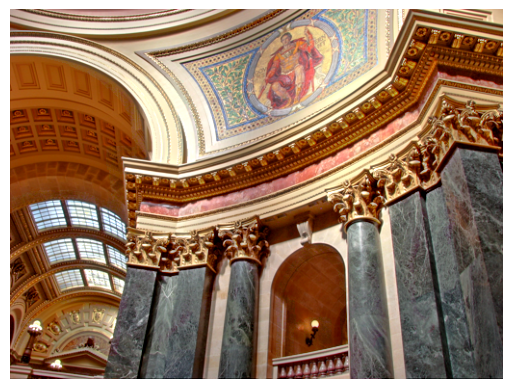

In [766]:
import matplotlib.pyplot as plt

# Assuming 'image_array' is your array with shape (height, width, 3)
plt.imshow(FI)
plt.axis('off')  # Turn off axis labels
plt.show()